# Face Recognition: How It Works Under the Hood

In the previous demonstration, we used a single command from the DeepFace library to find faces. It worked like magic, but how does the AI *actually* know if two faces match?

In this notebook, we'll go "under the hood" and break down the process into its core components. We will manually perform the four key steps of any modern face recognition pipeline:

1.  **Step 1: Detect and Align the Face.** First, we need to find a face in an image and prepare it for analysis.
2.  **Step 2: Create a Mathematical Representation (Embedding).** Next, we use a powerful AI model to convert the face image into a list of numbers—a unique "faceprint" or "embedding."
3.  **Step 3: Compare Representations.** We then calculate the mathematical "distance" between the embeddings of two faces.
4.  **Step 4: Make a Decision.** Finally, we use a threshold to decide if the faces are a match based on their distance.

Let's dive into each step.

## Step 1: Import Necessary Libraries 🛠️

First, we import the tools we need:
* `DeepFace`: The core AI library that contains pre-trained models for advanced face recognition.
* `cv2` (OpenCV) & `matplotlib`: Helper libraries for loading, processing, and displaying images.
* `numpy` The core library for numerical operations in Python. It's crucial here because images are represented as arrays of pixel values, and facial embeddings (the "faceprints") are numerical vectors. All mathematical operations in our pipeline will rely on NumPy.

In [ ]:
import cv2

import numpy as np
import і.pyplot as plt

from deepface.commons import image_utils
from deepface.modules import modeling, preprocessing
from deepface.models.FacialRecognition import FacialRecognition

## Step 2: Face Detection and Alignment

The first challenge is to locate a face within an image. A photo can contain multiple people, different backgrounds, and be taken from various angles. The system must first isolate the face of interest.

But just finding the face isn't enough. For accurate comparison, all faces must be standardized. This is called **alignment**. The `detect_faces` function we defined below does both:

1.  **Detects** the face using a pre-trained detector model.
2.  **Aligns** the face by cropping it from the background, rotating it so the eyes are level, and scaling it to a standard size.

You can see the output below: for each input image, we get a perfectly cropped and aligned face, ready for the next step.

In [ ]:
from deepface.modules.detection import expand_and_align_face

def detect_faces(img):

    height, width, _ = img.shape
    face_detector = modeling.build_model(
        task="face_detector", model_name="opencv"
    )

    height_border = int(0.5 * height)
    width_border = int(0.5 * width)
    img = cv2.copyMakeBorder(
        img,
        height_border,
        height_border,
        width_border,
        width_border,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0],
    )

    facial_areas = face_detector.detect_faces(img)

    return [
        expand_and_align_face(
            facial_area=facial_area,
            img=img,
            align=True,
            expand_percentage=0,
            width_border=width_border,
            height_border=height_border,
        )
        for facial_area in facial_areas
    ]

In [ ]:
def extract_faces(img_path) :
    resp_objs = []

    img, img_name = image_utils.load_image(img_path)
    height, width, _ = img.shape

    face_objs = detect_faces(img=img)

    for face_obj in face_objs:
        current_img = face_obj.img
        current_region = face_obj.facial_area

        current_img = current_img[:, :, ::-1]

        current_img = current_img / 255.0

        x = max(0, int(current_region.x))
        y = max(0, int(current_region.y))
        w = min(width - x - 1, int(current_region.w))
        h = min(height - y - 1, int(current_region.h))

        facial_area = {
            "x": x,
            "y": y,
            "w": w,
            "h": h,
            "left_eye": current_region.left_eye,
            "right_eye": current_region.right_eye,
        }

        resp_obj = {
            "face": current_img,
            "facial_area": facial_area,
            "confidence": round(float(current_region.confidence or 0), 2),
        }
        resp_objs.append(resp_obj)

    return resp_objs

## Step 3: Creating a Mathematical Representation (Embedding)

This is the heart of the recognition process. We don't compare images pixel by pixel. Instead, we use a deep learning model (in this case, `VGG-Face`) to convert each aligned face into a **mathematical representation**, also known as an **embedding** or a "faceprint."

An embedding is essentially a vector (a list) of numbers that uniquely describes the facial features. The `represent` function below orchestrates this:
1.  It takes an aligned face image.
2.  It performs final preprocessing (like normalizing colors).
3.  It feeds the image to the `VGG-Face` model.
4.  The model outputs a unique embedding for that face.

We will now generate these embeddings for our three aligned faces.

In [ ]:
def represent(img_path, model_name: str = "VGG-Face") :

    resp_objs = []

    model: FacialRecognition = modeling.build_model(
        task="facial_recognition", model_name=model_name
    )

    
    target_size = model.input_shape

    img_objs = extract_faces(img_path=img_path)


    for img_obj in img_objs:
        img = img_obj["face"]
        plt.imshow(img)  
        plt.axis("off")
        plt.show()

        img = img[:, :, ::-1]

        region = img_obj["facial_area"]
        confidence = img_obj["confidence"]
        print(confidence)

        img = preprocessing.resize_image(
            img=img,
            target_size=(target_size[1], target_size[0]),
        )

        img = preprocessing.normalize_input(img=img, normalization="base")

        embedding = model.forward(img)

        resp_objs.append(
            {
                "embedding": embedding,
                "facial_area": region,
                "face_confidence": confidence,
            }
        )

    return resp_objs


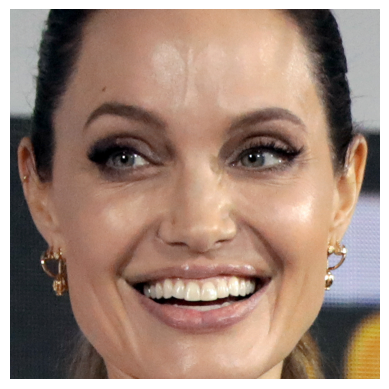

0.92


In [21]:
image1_angelina_rep = represent("B:\\robota\\deepface\\deepface\\tests\\dataset\\img1.jpg")

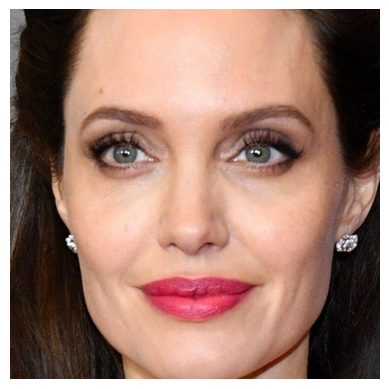

0.89


In [23]:
image2_angelina_rep = represent("B:\\robota\\deepface\\deepface\\tests\\dataset\\img2.jpg")

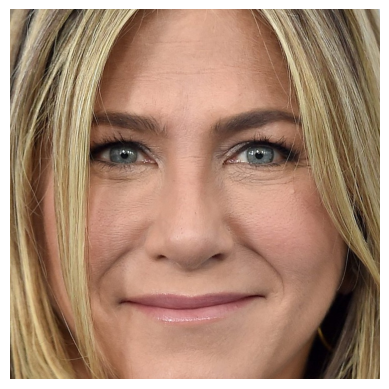

0.96


In [24]:
image_jenifer_rep = represent("B:\\robota\\deepface\\deepface\\tests\\dataset\\img3.jpg")

## Step 4 & 5: Comparing Embeddings and Making a Decision

Now that we have a unique "faceprint" for each person, how do we know if they match? We calculate the mathematical **distance** between their embedding vectors.

* If two faces belong to the **same person**, their embeddings will be very similar, and the calculated distance will be **small**.
* If the faces belong to **different people**, their embeddings will be dissimilar, and the distance will be **large**.

To make a final "verified" or "not verified" decision, we use a pre-defined **threshold**.
- If `distance <= threshold`: It's a match!
- If `distance > threshold`: It's not a match.

Let's test this. We'll compare two photos of Angelina Jolie against each other, and then compare one of her photos to a photo of Jennifer Aniston. The results should speak for themselves.

In [25]:
def find_euclidean_distance(source_representation, test_representation):

    source_representation = np.asarray(source_representation)
    test_representation = np.asarray(test_representation)

    if source_representation.ndim == 1 and test_representation.ndim == 1:
        distances = np.linalg.norm(source_representation - test_representation)
        
    return distances

In [ ]:
base_threshold = {"cosine": 0.40, "euclidean": 0.55, "euclidean_l2": 0.75}

thresholds = {
    # "VGG-Face": {"cosine": 0.40, "euclidean": 0.60, "euclidean_l2": 0.86}, # 2622d
    "VGG-Face": {
        "cosine": 0.68,
        "euclidean": 1.17,
        "euclidean_l2": 1.17,
    },  # 4096d - tuned with LFW
    "Facenet": {"cosine": 0.40, "euclidean": 10, "euclidean_l2": 0.80},
    "Facenet512": {"cosine": 0.30, "euclidean": 23.56, "euclidean_l2": 1.04},
    "ArcFace": {"cosine": 0.68, "euclidean": 4.15, "euclidean_l2": 1.13},
    "Dlib": {"cosine": 0.07, "euclidean": 0.6, "euclidean_l2": 0.4},
    "SFace": {"cosine": 0.593, "euclidean": 10.734, "euclidean_l2": 1.055},
    "OpenFace": {"cosine": 0.10, "euclidean": 0.55, "euclidean_l2": 0.55},
    "DeepFace": {"cosine": 0.23, "euclidean": 64, "euclidean_l2": 0.64},
    "DeepID": {"cosine": 0.015, "euclidean": 45, "euclidean_l2": 0.17},
    "GhostFaceNet": {"cosine": 0.65, "euclidean": 35.71, "euclidean_l2": 1.10},
}

In [33]:
threshold = 1.17

In [34]:
distance = find_euclidean_distance(image1_angelina_rep[0]['embedding'], image2_angelina_rep[0]['embedding'])


result = "verified" if distance <= threshold else "not verified"
print(distance)
result


0.9095226348398732


'verified'

In [35]:
distance = find_euclidean_distance(image1_angelina_rep[0]['embedding'], image_jenifer_rep[0]['embedding'])

result = "verified" if distance <= threshold else "not verified"
print(distance)
result


1.3524083008516625


'not verified'

In [36]:
distance = find_euclidean_distance(image2_angelina_rep[0]['embedding'], image_jenifer_rep[0]['embedding'])

result = "verified" if distance <= threshold else "not verified"
print(distance)
result


1.362482473795124


'not verified'

## Conclusion: From a Single Comparison to a Full Database Search

We have successfully demonstrated the core of the technology: **Face Verification**. By converting faces into mathematical embeddings and measuring the distance between them, we can reliably determine if two images show the same person.

**And now, how do we use this to find out who a person is?**

Imagine we have a database of registered users, with a pre-calculated embedding stored for each user's profile picture.

When a new photo appears online, we simply apply the exact procedure we just performed:

1.  We detect the face in the new photo and calculate its unique **embedding**.
2.  We then perform our distance comparison, not just against one photo, but against **every user embedding in our database**.
3.  The user whose stored embedding has the smallest distance to the new embedding (and is below our defined threshold) is identified as the match.

This is how we move from **Verification** (answering *"Is this Person A?"*) to **Recognition** (answering *"Who is this person?"*). By applying the simple verification process on a large scale, we can accurately find and identify individuals from a vast collection of images, protecting our users' digital identity.